In [1]:
# Итоговое задание

# Нужно предсказать, сможет ли пользователь успешно закончить онлайн курс Анализ данных в R.
# Будем считать, что пользователь успешно закончил курс, если он правильно решил больше 40 практических заданий.
# В данных: submission_data_test.csv и events_data_test.csv хранится информация о решениях и действиях для 6184 студентов
# за первые два дня прохождения курса. Это 6184 студентов, которые проходили курс в период с мая 2018 по январь 2019. 
# Используя данные о первых двух днях активности на курсе вам нужно предсказать,
# наберет ли пользователь более 40 баллов на курсе или нет.
# В этих данных, вам доступны только первые дня активности студентов для того, чтобы сделать предсказание.
# На самом деле, используя эти данные, вы уже можете сделать прогноз.
# Например, если пользователь за первые два дня набрал 40 баллов, скорее всего он наберет более 40 баллов в дальнейшем.
# Чтобы подкрепить такие гипотезы, вы можете использовать данные, на которые мы исследовали в первых двух модулях курса,
# где для всех пользователей представлены все данные об их активности на курсе.

In [2]:
import numpy as np
import pandas as pd

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Выгрузим тренировочные данные
event_data_train = pd.read_csv("https://stepik.org/media/attachments/course/4852/event_data_train.zip", compression="zip")
event_data_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [6]:
submissions_data_train = pd.read_csv("https://stepik.org/media/attachments/course/4852/submissions_data_train.zip", compression="zip")
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
# Выгрузим тестовые данные
events_data_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/events_data_test.csv")
events_data_test.head()

,step_id,timestamp,action,user_id
0,30456,1526893787,viewed,24417
1,30456,1526893797,viewed,24417
2,30456,1526893954,viewed,24417
3,30456,1526895780,viewed,24417
4,30456,1526893787,discovered,24417


In [8]:
submission_data_test = pd.read_csv("https://stepik.org/media/attachments/course/4852/submission_data_test.csv")
submission_data_test.head()

,step_id,timestamp,submission_status,user_id
0,31971,1526800961,wrong,24370
1,31971,1526800976,wrong,24370
2,31971,1526800993,wrong,24370
3,31971,1526801054,correct,24370
4,31972,1526800664,wrong,24370


In [9]:
# Описание данных
event_data_train.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [10]:
event_data_train["action"].unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [11]:
submissions_data_train.dtypes

step_id               int64
timestamp             int64
submission_status    object
user_id               int64
dtype: object

In [12]:
submissions_data_train["submission_status"].unique()

array(['correct', 'wrong'], dtype=object)

In [13]:
# Создадим новые колонки:
# - колонку, в которой значение из колонки timestamp будет переведено в формат даты.
# - колонку, в которая будет являться днём.
events_data_test["date"] = pd.to_datetime(events_data_test["timestamp"], unit="s")
events_data_test["day"] = events_data_test["date"].dt.date
events_data_test.head()

,step_id,timestamp,action,user_id,date,day
0,30456,1526893787,viewed,24417,2018-05-21 09:09:47,2018-05-21
1,30456,1526893797,viewed,24417,2018-05-21 09:09:57,2018-05-21
2,30456,1526893954,viewed,24417,2018-05-21 09:12:34,2018-05-21
3,30456,1526895780,viewed,24417,2018-05-21 09:43:00,2018-05-21
4,30456,1526893787,discovered,24417,2018-05-21 09:09:47,2018-05-21


In [14]:
submission_data_test["date"] = pd.to_datetime(submission_data_test["timestamp"], unit="s")
submission_data_test["day"] = submission_data_test["date"].dt.date
submission_data_test.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1526800961,wrong,24370,2018-05-20 07:22:41,2018-05-20
1,31971,1526800976,wrong,24370,2018-05-20 07:22:56,2018-05-20
2,31971,1526800993,wrong,24370,2018-05-20 07:23:13,2018-05-20
3,31971,1526801054,correct,24370,2018-05-20 07:24:14,2018-05-20
4,31972,1526800664,wrong,24370,2018-05-20 07:17:44,2018-05-20


In [15]:
event_data_train["date"] = pd.to_datetime(event_data_train["timestamp"], unit="s")
event_data_train["day"] = event_data_train["date"].dt.date
event_data_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [16]:
submissions_data_train["date"] = pd.to_datetime(submissions_data_train["timestamp"], unit="s")
submissions_data_train["day"] = submissions_data_train.date.dt.date
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


<Axes: xlabel='day'>

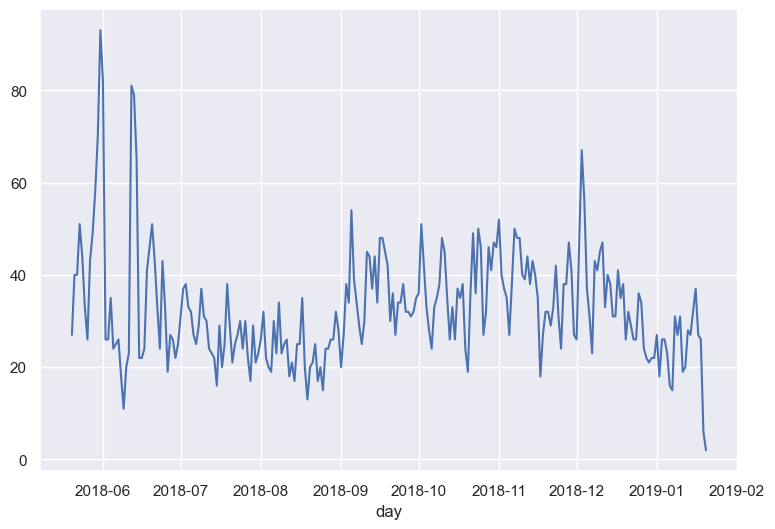

In [17]:
# Теперь построим графики активности студентов за всё время
sns.set(rc={"figure.figsize": (9, 6)})
events_data_test.groupby(["day"])["user_id"].nunique().plot()

<Axes: xlabel='day'>

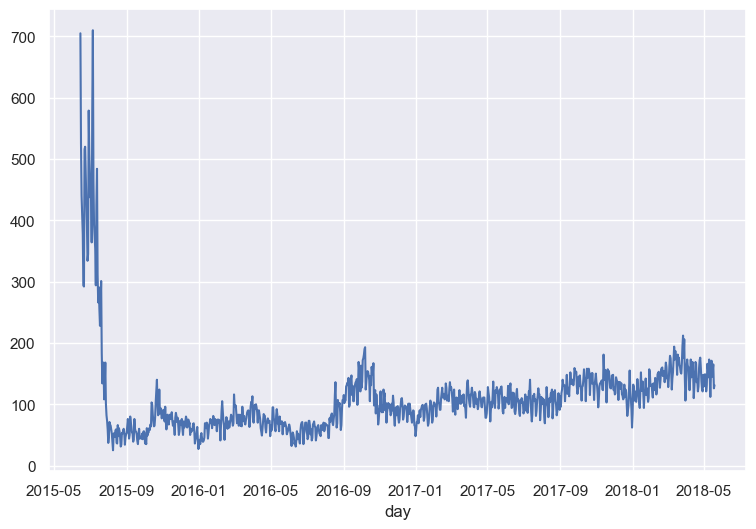

In [18]:
sns.set(rc={"figure.figsize": (9, 6)})
event_data_train.groupby(["day"])["user_id"].nunique().plot()

In [19]:
# Соберем таблицу users_scores с баллами участников
users_scores = submission_data_test.pivot_table(
    index="user_id",
    columns="submission_status",
    values="step_id",
    aggfunc="count"
).fillna(0).reset_index()
users_scores.head()

submission_status,user_id,correct,wrong
0,12,1.0,0.0
1,13,29.0,36.0
2,15,10.0,30.0
3,21,24.0,103.0
4,35,7.0,35.0


/Users/narek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='correct', ylabel='Count'>

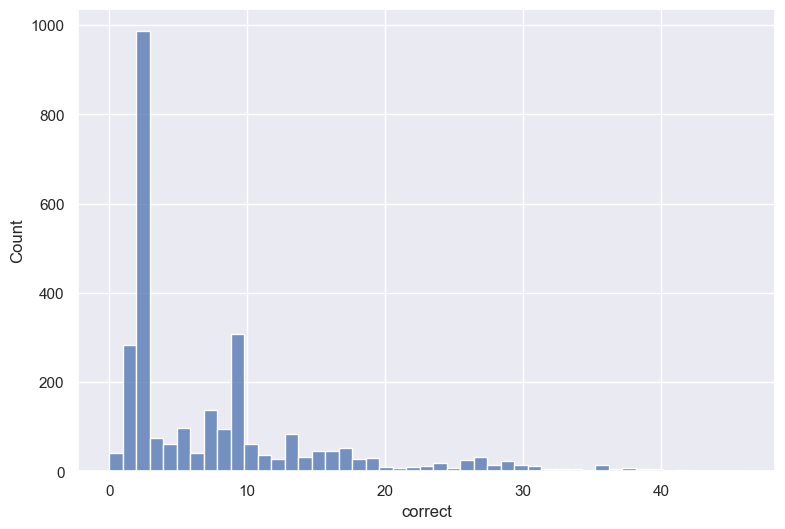

In [20]:
# Построим гистограмму правильных ответов за первые 3 дня
sns.histplot(data=users_scores["correct"])

<Axes: >

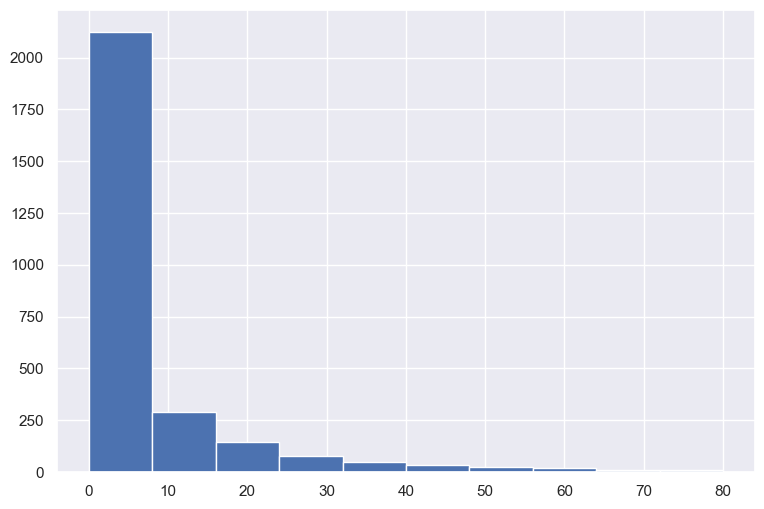

In [21]:
# Построим гистограмму неправильных ответов за первые 3 дня
users_scores[users_scores.wrong <= 80]["wrong"].hist()

/Users/narek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='wrong', ylabel='Count'>

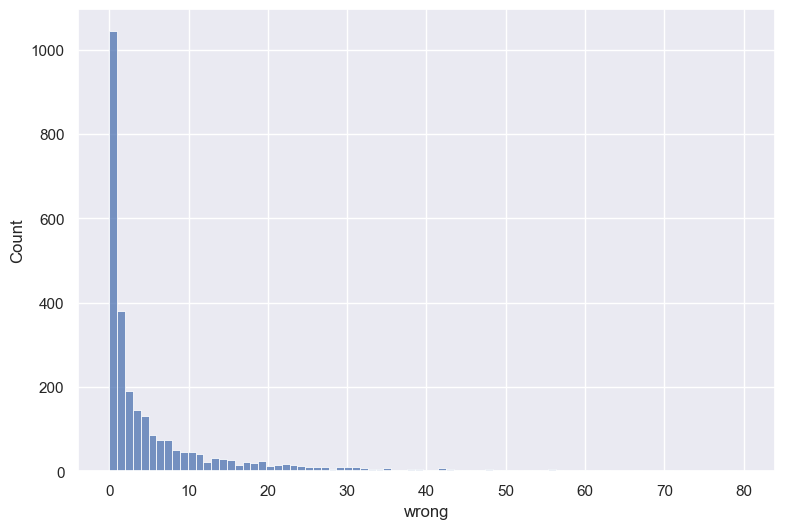

In [22]:
# Построим гистограмму неправильных ответов
sns.histplot(data=users_scores[users_scores.wrong <= 80]["wrong"])

In [23]:
# Только 0.3% пользователей набирают больше 40 баллов за курс за первые два дня
# Значение получено подбором
users_scores.correct.quantile(0.997)

40.0

In [24]:
# Посчитаем значение за все время
users_scores_all_time = submissions_data_train.pivot_table(
    index="user_id",
    columns="submission_status",
    values="step_id",
    aggfunc="count"
).fillna(0).reset_index()
users_scores_all_time.head()

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


/Users/narek/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='correct', ylabel='Count'>

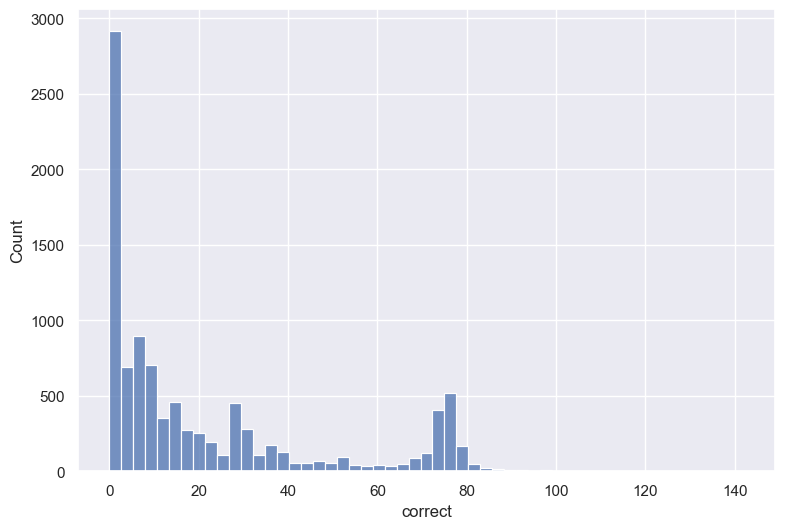

In [25]:
# Гистограмма правильных решений за все время
sns.histplot(data=users_scores_all_time[users_scores_all_time.correct <= 150]["correct"])

In [26]:
# За всё время 20% процентов пользователей набрали больше, чем 40 баллов на курсе
users_scores_all_time.correct.quantile(0.8)

40.0

In [27]:
# Отберём данные о первых активных действиях пользователя на курсе
user_min_time = event_data_train.groupby("user_id", as_index=False).agg({"timestamp": "min"}).rename(columns={"timestamp": "min_timestamp"})
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [28]:
# Теперь нужно для данных, хранящихся в submissions_data_train отобрать для каждого пользователя те события,
# которые вписываются в промежуток первых двух дней после начала курса.
# Создадим в submissions_data_train новую колонку user_time
submissions_data_train["user_time"] = submissions_data_train.user_id.apply(str) + "_" + submissions_data_train.timestamp.apply(str)
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123


In [29]:
learning_time_treshold = 2 * 24 * 60 * 60
time_diff = (user_min_time.min_timestamp + learning_time_treshold).apply(str)
user_min_time["user_learning_time_treshold"] = user_min_time.user_id.apply(str) + "_" + time_diff
user_min_time.head()

,user_id,min_timestamp,user_learning_time_treshold
0,1,1472827464,1_1473000264
1,2,1514383364,2_1514556164
2,3,1434358476,3_1434531276
3,5,1466156809,5_1466329609
4,7,1521634660,7_1521807460


In [30]:
# Сделаем мёрдж данных с датафреймом user_min_time, отобрав из него только нужные данные
submissions_data_train = submissions_data_train.merge(user_min_time[["user_id", "user_learning_time_treshold"]], on="user_id", how="outer")
submissions_data_train.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
2,31972.0,1.478852e+09,wrong,15853,2016-11-11 08:15:49,2016-11-11,15853_1478852149,15853_1434518777
3,31972.0,1.478852e+09,correct,15853,2016-11-11 08:16:04,2016-11-11,15853_1478852164,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777


In [31]:
#  Теперь для каждого пользователя достаточно узнать - "правда ли, что его время выполнения каждого действия 
# вписыается в нужный диапазон?" Для этого будем сравнивать строки как инты.
submission_data_two_days = submissions_data_train[submissions_data_train.user_time <= submissions_data_train.user_learning_time_treshold]
submission_data_two_days.head()

,step_id,timestamp,submission_status,user_id,date,day,user_time,user_learning_time_treshold
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,15853_1434349275,15853_1434518777
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,15853_1434348300,15853_1434518777
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,15853_1434348123,15853_1434518777
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,15853_1434348188,15853_1434518777
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,15853_1434347371,15853_1434518777


In [32]:
# Проверим, что мы не выходим за заданный промежуток в 3 дня
submission_data_two_days.groupby("user_id")["day"].nunique().max()

3

In [33]:
# Тоже самое с events_data_test
event_data_train["user_time"] = event_data_train.user_id.apply(str) + "_" + event_data_train.timestamp.apply(str)
event_data_train = event_data_train.merge(user_min_time[["user_id", "user_learning_time_treshold"]], how="outer")
events_data_two_days = event_data_train[event_data_train.user_time <= event_data_train.user_learning_time_treshold]
events_data_two_days.groupby("user_id").day.nunique().max()

3

In [34]:
# Подготовим массив признаков
X_train = submission_data_two_days.groupby("user_id").day.nunique().to_frame().reset_index().rename(columns={"day": "days"})
X_train.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,2


In [35]:
X_test = submission_data_test.groupby("user_id").day.nunique().to_frame().reset_index().rename(columns={"day": "days"})
X_test.head()

,user_id,days
0,12,1
1,13,2
2,15,3
3,21,1
4,35,3


In [36]:
# Массив пройденных степов
step_tried = submission_data_two_days.groupby("user_id").step_id.nunique().to_frame().reset_index().rename(columns={"step_id": "steps_tried"})
step_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,18


In [37]:
# Смерджим полученный массив с терировочным и тестовым массивами признаков
X_train = X_train.merge(step_tried, on="user_id", how="outer")
X_train.head()

,user_id,days,steps_tried
0,2,1,2
1,3,1,4
2,8,1,11
3,14,1,1
4,16,2,18


In [38]:
X_test = X_test.merge(
    submission_data_test.groupby("user_id").step_id.nunique().to_frame().reset_index().rename(columns={
        "step_id": "steps_tried"
    }),
    on="user_id", how="outer"
)
X_test.head()

,user_id,days,steps_tried
0,12,1,1
1,13,2,29
2,15,3,11
3,21,1,30
4,35,3,9


In [39]:
users_scores_all_time.head()

submission_status,user_id,correct,wrong
0,2,2.0,0.0
1,3,29.0,23.0
2,5,2.0,2.0
3,8,9.0,21.0
4,14,0.0,1.0


In [40]:
X_train = X_train.merge(users_scores_all_time, on="user_id", how="outer")
X_train.head()

,user_id,days,steps_tried,correct,wrong
0,2,1.0,2.0,2.0,0.0
1,3,1.0,4.0,29.0,23.0
2,8,1.0,11.0,9.0,21.0
3,14,1.0,1.0,0.0,1.0
4,16,2.0,18.0,77.0,106.0


In [41]:
X_test = X_test.merge(users_scores, on="user_id", how="outer")
X_test.head()

,user_id,days,steps_tried,correct,wrong
0,12,1,1,1.0,0.0
1,13,2,29,29.0,36.0
2,15,3,11,10.0,30.0
3,21,1,30,24.0,103.0
4,35,3,9,7.0,35.0


In [42]:
# Добавим параметр correction_ratio
X_train["correction_ratio"] = X_train.correct / (X_train.correct + X_train.wrong)
X_train.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio
0,2,1.0,2.0,2.0,0.0,1.000000
1,3,1.0,4.0,29.0,23.0,0.557692
2,8,1.0,11.0,9.0,21.0,0.300000
3,14,1.0,1.0,0.0,1.0,0.000000
4,16,2.0,18.0,77.0,106.0,0.420765


In [43]:
X_test["correction_ratio"] = X_test.correct / (X_test.correct + X_test.wrong)
X_test.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio
0,12,1,1,1.0,0.0,1.000000
1,13,2,29,29.0,36.0,0.446154
2,15,3,11,10.0,30.0,0.250000
3,21,1,30,24.0,103.0,0.188976
4,35,3,9,7.0,35.0,0.166667


In [44]:
# Составим таблицу промотренных степов
viewed_steps_count = events_data_two_days.pivot_table(
    index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()[["user_id", "viewed"]]
viewed_steps_count.head()

action,user_id,viewed
0,1,1
1,2,9
2,3,20
3,5,1
4,7,1


In [45]:
# Смерджим её с массивами признаков
X_train = X_train.merge(viewed_steps_count, on="user_id", how="outer")
X_train.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.000000,9
1,3,1.0,4.0,29.0,23.0,0.557692,20
2,8,1.0,11.0,9.0,21.0,0.300000,154
3,14,1.0,1.0,0.0,1.0,0.000000,9
4,16,2.0,18.0,77.0,106.0,0.420765,117


In [46]:
X_test = X_test.merge(
    events_data_test.pivot_table(index="user_id",
    columns="action",
    values="step_id",
    aggfunc="count",
    fill_value=0
).reset_index()[["user_id", "viewed"]], on="user_id", how="outer")
X_test.head()

,user_id,days,steps_tried,correct,wrong,correction_ratio,viewed
0,12,1.0,1.0,1.0,0.0,1.000000,14
1,13,2.0,29.0,29.0,36.0,0.446154,105
2,15,3.0,11.0,10.0,30.0,0.250000,1
3,21,1.0,30.0,24.0,103.0,0.188976,98
4,35,3.0,9.0,7.0,35.0,0.166667,70


In [47]:
# Заполним пустые значения
X_train = X_train.fillna(0)
X_train = X_train.set_index(X_train.user_id)
X_train = X_train.drop(["user_id"], axis=1)
X_train.head()

,days,steps_tried,correct,wrong,correction_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.000000,9
3,1.0,4.0,29.0,23.0,0.557692,20
8,1.0,11.0,9.0,21.0,0.300000,154
14,1.0,1.0,0.0,1.0,0.000000,9
16,2.0,18.0,77.0,106.0,0.420765,117


In [48]:
X_test = X_test.fillna(0)
X_test = X_test.set_index(X_test.user_id)
X_test = X_test.drop(["user_id"], axis=1)
X_test.head()

,days,steps_tried,correct,wrong,correction_ratio,viewed
user_id,,,,,,
12,1.0,1.0,1.0,0.0,1.000000,14
13,2.0,29.0,29.0,36.0,0.446154,105
15,3.0,11.0,10.0,30.0,0.250000,1
21,1.0,30.0,24.0,103.0,0.188976,98
35,3.0,9.0,7.0,35.0,0.166667,70


<Axes: >

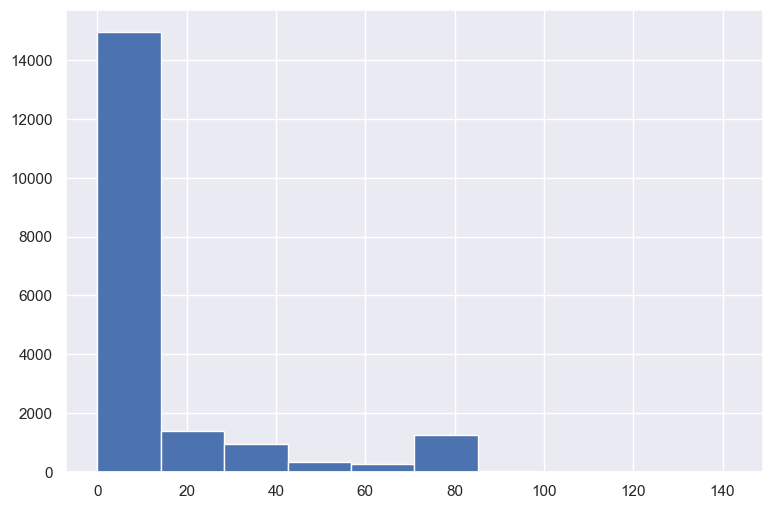

In [49]:
# Гистограмма правильных ответов для тренировочных данных
X_train[X_train.correct <= 150]["correct"].hist()

In [50]:
X_train[X_train.correct >= 40]["correct"].count()

2013

In [51]:
X_train.correct.quantile(0.95)

75.0

In [52]:
# Примерно 10% пользователей получили больше 40 баллов на курсе за первые два дня
X_train.correct.quantile(0.896)

40.0

In [53]:
# Массив резултатов
y_train = X_train.correct >= 40
y_train = y_train.apply(int)
y_train.head()

user_id
2     0
3     0
8     0
14    0
16    1
Name: correct, dtype: int64

In [54]:
# Подготовим классификатор RandomForest для предсказания данных
parametrs = {
    "n_estimators": range(2, 20),
    "max_depth": range(1, 5),
    "min_samples_leaf": range(2, 8),
    "min_samples_split": range(2, 10, 2),
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=parametrs, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 5),
                         'min_samples_leaf': range(2, 8),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(2, 20)})

In [55]:
# Получим лучшие параметры для нашего классификатора
grid_search.best_params_

{'max_depth': 1,
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 4}

In [56]:
# Лучшее решение
best_estimator = grid_search.best_estimator_
best_estimator

RandomForestClassifier(max_depth=1, min_samples_leaf=2, min_samples_split=6,
                       n_estimators=4)

In [57]:
# Предсказанные значения
y_predicted = grid_search.predict_proba(X_test)[:, 1]
y_predicted

array([0.02294565, 0.28259446, 0.1245336 , ..., 0.02294565, 0.02294565,
       0.02294565])

In [58]:
# Результирующий датафрейм
result = pd.DataFrame(data={"user_id": X_test.index, "is_gone": y_predicted})
result.head()

,user_id,is_gone
0,12,0.022946
1,13,0.282594
2,15,0.124534
3,21,0.282594
4,35,0.022946


In [59]:
# Запишем результат в csv-файл
result.to_csv("files/output.csv", index=False)

In [60]:
# Your ROC score is 0.7108536384770779